In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

In [2]:
np.random.seed(42)

In [3]:
indonesian_cities = [
    "Medan", "Surabaya", "Jakarta", "Bandung", "Semarang",
    "Palembang", "Makassar", "Bogor", "Yogyakarta", "Malang",
    "Denpasar", "Balikpapan", "Pontianak", "Banjarmasin", "Pekanbaru",
    "Manado", "Jayapura", "Kupang", "Ternate", "Mataram"
]

In [4]:
city_coords = np.array([
    [3.5952, 98.6722], [-7.2575, 112.7521], [-6.2088, 106.8456], [-6.9175, 107.6191],
    [-7.0051, 110.4381], [-2.9761, 104.7754], [-5.1477, 119.4327], [-6.5897, 106.7914],
    [-7.7972, 110.3688], [-7.9839, 112.6214], [-8.6500, 115.2167], [-1.2674, 116.8289],
    [-0.0266, 109.3425], [-3.3190, 114.5900], [0.5333, 101.4500], [1.4919, 124.8419],
    [-2.5330, 140.7181], [-10.1689, 123.5833], [0.7910, 127.3812], [-8.5833, 116.1167],
])

num_cities = len(indonesian_cities)

In [5]:
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

base_distance_matrix = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        base_distance_matrix[i,j] = haversine(city_coords[i], city_coords[j])

np.random.seed(42)
base_cost_matrix = base_distance_matrix * (0.5 + np.random.rand(num_cities, num_cities))
base_cost_matrix = (base_cost_matrix + base_cost_matrix.T)/2

num_ants = 50
num_iterations = 100
evaporation_rate = 0.3
Q = 150

pheromone_distance = np.ones((num_cities, num_cities))
pheromone_cost = np.ones((num_cities, num_cities))

def dynamic_alpha_beta(iteration, max_iter):
    alpha = 1 + 4 * (iteration / max_iter)
    beta = 5 - 4 * (iteration / max_iter)
    return alpha, beta

def calculate_route_length(route, dist_matrix):
    length = 0
    for i in range(len(route)-1):
        length += dist_matrix[route[i], route[i+1]]
    length += dist_matrix[route[-1], route[0]]
    return length

def two_opt(route, dist_matrix):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route)-2):
            for j in range(i+1, len(route)):
                if j - i == 1:
                    continue
                new_route = best[:]
                new_route[i:j] = best[j-1:i-1:-1]
                if calculate_route_length(new_route, dist_matrix) < calculate_route_length(best, dist_matrix):
                    best = new_route
                    improved = True
        route = best
    return best

def select_next_city(current_city, visited, alpha, beta, dist_matrix, cost_matrix, w_dist=0.7, w_cost=0.3):
    pher_dist = pheromone_distance[current_city]
    pher_cost = pheromone_cost[current_city]
    distances = dist_matrix[current_city]
    costs = cost_matrix[current_city]

    mask = np.ones(len(pher_dist), dtype=bool)
    mask[visited] = False

    pher_dist = pher_dist[mask]
    pher_cost = pher_cost[mask]
    distances = distances[mask]
    costs = costs[mask]

    available_cities = np.where(mask)[0]

    pheromone_total = (pher_dist ** alpha) * (pher_cost ** alpha)
    heuristic_dist = (1 / distances) ** beta
    heuristic_cost = (1 / costs) ** beta
    heuristic_total = w_dist * heuristic_dist + w_cost * heuristic_cost

    probabilities = pheromone_total * heuristic_total
    probabilities = probabilities / probabilities.sum()

    next_city_idx = np.random.choice(len(probabilities), p=probabilities)
    return available_cities[next_city_idx]

In [6]:
def ant_run(args):
    iteration, alpha, beta, dist_matrix, cost_matrix = args
    route = []
    visited = []
    current_city = np.random.randint(num_cities)
    route.append(current_city)
    visited.append(current_city)

    while len(route) < num_cities:
        next_city = select_next_city(current_city, visited, alpha, beta, dist_matrix, cost_matrix)
        route.append(next_city)
        visited.append(next_city)
        current_city = next_city

    route = two_opt(route, dist_matrix)
    length = calculate_route_length(route, dist_matrix)
    cost = calculate_route_length(route, cost_matrix)
    return route, length, cost

def dynamic_distance_matrix(base_dist, iteration):
    noise_level = 0.05
    noise = (np.random.rand(num_cities, num_cities) - 0.5) * 2 * noise_level * base_dist
    noise = (noise + noise.T) / 2
    dist = base_dist + noise
    np.fill_diagonal(dist, 0)
    return dist

pheromone_distance_snapshots = []
pheromone_cost_snapshots = []
routes_snapshots = []
scores_snapshots = []

best_route = None
best_length = np.inf
best_cost = np.inf
best_scores = []
best_routes = []

for iteration in range(num_iterations):
    alpha, beta = dynamic_alpha_beta(iteration, num_iterations)

    dist_matrix = dynamic_distance_matrix(base_distance_matrix, iteration)
    cost_matrix = base_cost_matrix

    with mp.Pool(processes=8) as pool:
        ants_args = [(iteration, alpha, beta, dist_matrix, cost_matrix) for _ in range(num_ants)]
        results = pool.map(ant_run, ants_args)

    all_routes = [r for r, l, c in results]
    all_lengths = [l for r, l, c in results]
    all_costs = [c for r, l, c in results]

    w_dist = 0.7
    w_cost = 0.3
    all_scores = [w_dist*l + w_cost*c for l, c in zip(all_lengths, all_costs)]

    best_ant_idx = np.argmin(all_scores)
    best_ant_route = all_routes[best_ant_idx]
    best_ant_length = all_lengths[best_ant_idx]
    best_ant_cost = all_costs[best_ant_idx]

    if all_scores[best_ant_idx] < (w_dist*best_length + w_cost*best_cost):
        best_route = best_ant_route
        best_length = best_ant_length
        best_cost = best_ant_cost

    pheromone_distance = (1 - evaporation_rate) * pheromone_distance
    pheromone_cost = (1 - evaporation_rate) * pheromone_cost

    for route, length, cost in zip(all_routes, all_lengths, all_costs):
        score = w_dist*length + w_cost*cost
        deposit = Q / score
        for i in range(len(route)-1):
            pheromone_distance[route[i], route[i+1]] += deposit
            pheromone_cost[route[i], route[i+1]] += deposit
        pheromone_distance[route[-1], route[0]] += deposit
        pheromone_cost[route[-1], route[0]] += deposit

    best_scores.append(w_dist*best_length + w_cost*best_cost)
    best_routes.append(best_route)

    if iteration % 10 == 0 or iteration == num_iterations - 1:
        pheromone_distance_snapshots.append(pheromone_distance.copy())
        pheromone_cost_snapshots.append(pheromone_cost.copy())
        routes_snapshots.append(best_route.copy())
        scores_snapshots.append(best_scores[-1])

    print(f"Iter {iteration+1}/{num_iterations} Best score: {best_scores[-1]:.2f} Length: {best_length:.2f} Cost: {best_cost:.2f}")

Iter 1/100 Best score: 11284.65 Length: 11226.25 Cost: 11420.93
Iter 2/100 Best score: 11284.65 Length: 11226.25 Cost: 11420.93
Iter 3/100 Best score: 11172.63 Length: 11052.44 Cost: 11453.07
Iter 4/100 Best score: 11172.63 Length: 11052.44 Cost: 11453.07
Iter 5/100 Best score: 11172.63 Length: 11052.44 Cost: 11453.07
Iter 6/100 Best score: 11172.63 Length: 11052.44 Cost: 11453.07
Iter 7/100 Best score: 11172.63 Length: 11052.44 Cost: 11453.07
Iter 8/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 9/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 10/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 11/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 12/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 13/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 14/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 15/100 Best score: 11067.87 Length: 10915.22 Cost: 11424.06
Iter 16/100 Best score: 11067.87 L

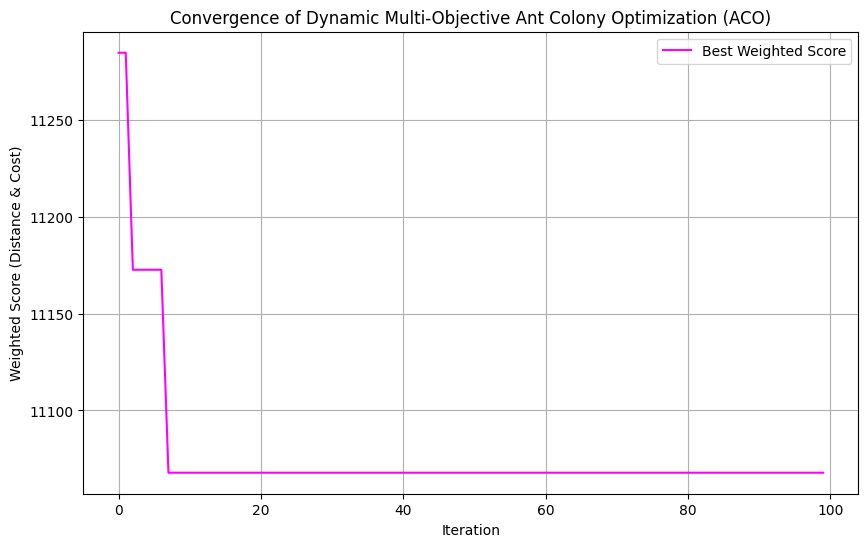

In [14]:
plt.figure(figsize=(10,6))
plt.plot(best_scores, label="Best Weighted Score", color='magenta')
plt.xlabel("Iteration")
plt.ylabel("Weighted Score (Distance & Cost)")
plt.title("Convergence of Dynamic Multi-Objective Ant Colony Optimization (ACO)")
plt.legend()
plt.grid(True)
plt.show()


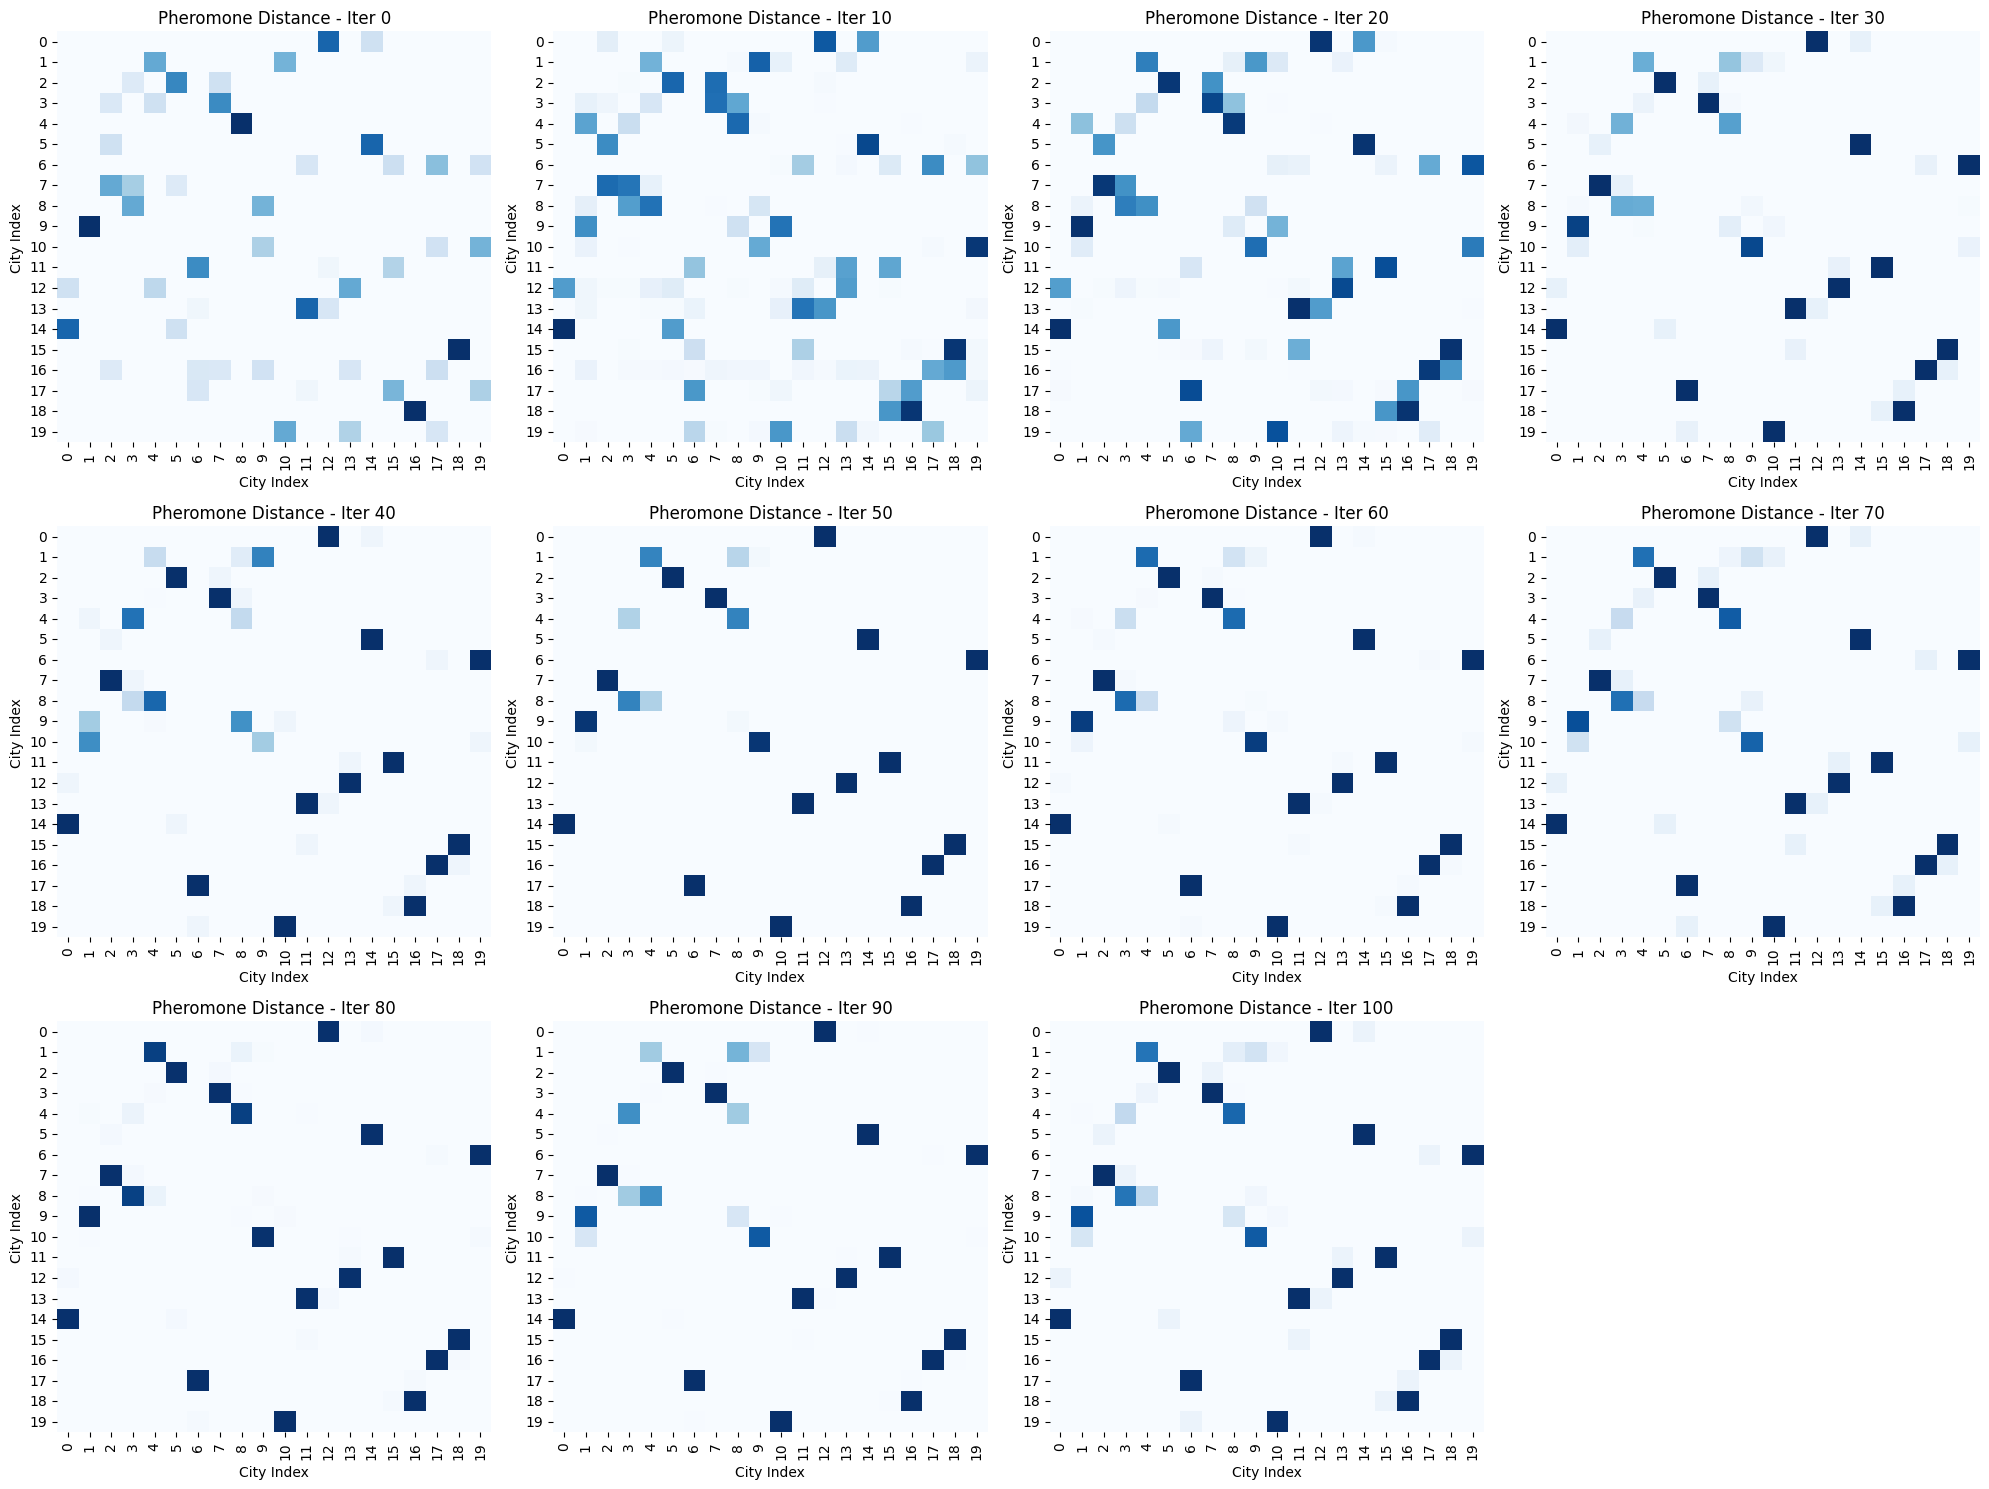

In [21]:
num_snapshots = len(pheromone_distance_snapshots)
cols = 4
rows = int(np.ceil(num_snapshots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

if rows == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, pheromone in enumerate(pheromone_distance_snapshots):
    r = idx // cols
    c = idx % cols
    ax = axes[r, c]
    sns.heatmap(pheromone, cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f"Pheromone Distance - Iter {idx*10}")
    ax.set_xlabel("City Index")
    ax.set_ylabel("City Index")

for idx in range(len(pheromone_distance_snapshots), rows * cols):
    r = idx // cols
    c = idx % cols
    fig.delaxes(axes[r, c])

plt.tight_layout()
plt.show()

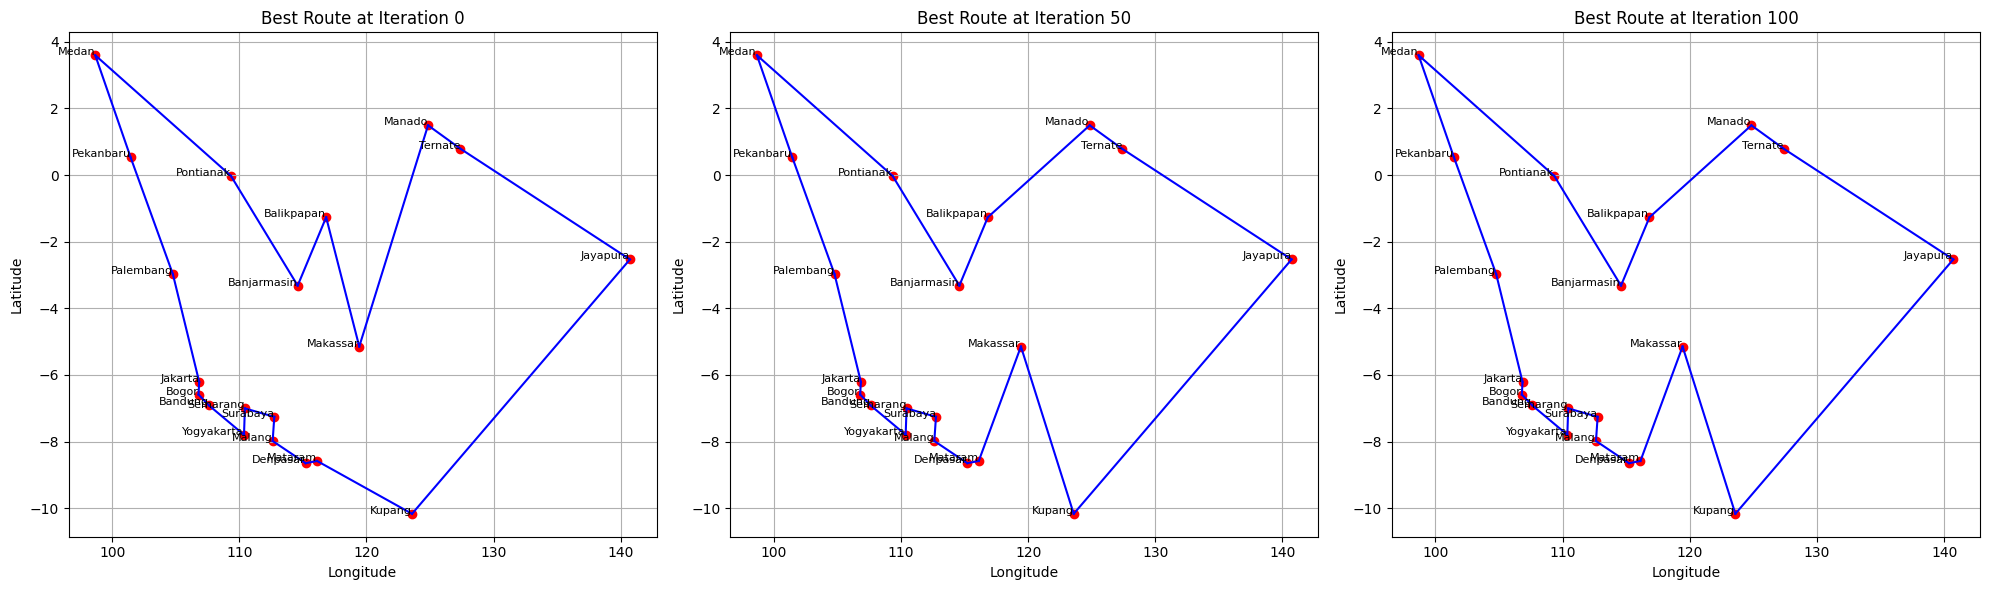

In [22]:
def plot_route_subplot(route, coords, cities, title, ax):
    x = coords[:,1]
    y = coords[:,0]
    ax.scatter(x, y, c='red')
    for i, city in enumerate(cities):
        ax.text(x[i], y[i], city, fontsize=8, ha='right')
    for i in range(len(route)-1):
        ax.plot([x[route[i]], x[route[i+1]]], [y[route[i]], y[route[i+1]]], 'b-')
    ax.plot([x[route[-1]], x[route[0]]], [y[route[-1]], y[route[0]]], 'b-')
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

idx_awal = 0
idx_tengah = len(routes_snapshots) // 2
idx_akhir = len(routes_snapshots) - 1

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

plot_route_subplot(routes_snapshots[idx_awal], city_coords, indonesian_cities, f"Best Route at Iteration 0", axs[0])
plot_route_subplot(routes_snapshots[idx_tengah], city_coords, indonesian_cities, f"Best Route at Iteration {idx_tengah * 10}", axs[1])
plot_route_subplot(routes_snapshots[idx_akhir], city_coords, indonesian_cities, f"Best Route at Iteration {idx_akhir * 10}", axs[2])

plt.tight_layout()
plt.show()